# 15 Minute Series: Spatial Analysis of Washington DC
---

*Cara Higashi, Robert Lopez, Joseph Sy, Giovanni Ramos Gutierrez*

## Data Import
---

### DataStore Import from GeoSnap

In [1]:
from geosnap import DataStore
import warnings
warnings.filterwarnings('ignore')
datasets = DataStore("/srv/data/geonsap")

/opt/tljh/user/lib/python3.10/site-packages/numba/core/decorators.py:262: NumbaDeprecationWarning: numba.generated_jit is deprecated. Please see the documentation at: https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-generated-jit for more information and advice on a suitable replacement.
  warnings.warn(msg, NumbaDeprecationWarning)
/opt/tljh/user/lib/python3.10/site-packages/quantecon/lss.py:20: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def simulate_linear_model(A, x0, v, ts_length):


In [2]:
import os
import pandana as pdna

network_path = './networks/47900.h5'

if not os.path.exists(network_path):
    import quilt3 as q3
    b = q3.Bucket("s3://spatial-ucr")
    b.fetch("osm/metro_networks_8k/47900.h5", network_path)
dc_network = pdna.Network.from_hdf5(network_path)

Generating contraction hierarchies with 32 threads.
Setting CH node vector of size 943540
Setting CH edge vector of size 1466574
Range graph removed 440968 edges of 2933148
. 10% . 20% . 30% . 40% . 50% . 60% . 70% . 80% . 90% . 100%


The line of code above imports the os module for interacting with the operating system and pandana as pdna for network analysis functionalities. It checks if a file named '47900.h5' already exists in the local directory using os.path.exists. If the file does not exist, it proceeds with the next steps.  It imports the quilt3 module as q3, which is used for managing and deploying data packages. It creates a connection to a specific Quilt bucket located at "s3://spatial-ucr". This bucket is presumably where data files are stored. It fetches a file named 'osm/metro_networks_8k/47900.h5' from the specified bucket and saves it locally as '47900.h5'. This file contains data for a transportation or network dataset, suggested by the path and naming convention. It uses pandana to load the network data from the local '47900.h5' file into a variable called dc_network.

### Geopandas import to read files

In [3]:
import geopandas as gpd

In [4]:
file_path = 'data/dc_boundary/Washington_DC_Boundary.shp'
dc_boundary = gpd.read_file(file_path)

In [5]:
# dc_boundary.explore()

When analyzing transit stop locations, it was noted that some data points fell outside the boundaries of Washington DC. To address this, a spatial join was performed using the defined boundary of Washington DC to isolate and identify the transit stops located within the city limits. This method ensured that only relevant data points were included in the analysis.

### DC Schools

In [6]:
schools = datasets.nces(dataset="schools")


In [7]:
dc_schools = schools[schools["STFIP15"] == "11"]


A GeoDataFrame named "dc_schools" was created to include only the schools located within Washington DC. This was achieved by subsetting the data using the column "STFIP15," where only entries with a value of "11" were retained. The number "11" corresponds to the FIPS state code for Washington DC, ensuring that the GeoDataFrame accurately represents schools in the specified region.

In [8]:
# dc_schools

In [9]:
# dc_schools.explore()

### Creating Isochrones for DC Schools

In [10]:
from geosnap.analyze import isochrones_from_id, isochrones_from_gdf, pdna_to_adj 

```isochrones = isochrones_from_gdf(dc_schools, threshold=1600, network=dc_network)```

```schools_iso = isochrones.dissolve()```

```schools_iso.to_file('data/dc_schools_iso')```

In [11]:
file_path="data/dc_schools_iso/dc_schools_iso.shp"
schools_iso=gpd.read_file(file_path)

Isochrones were generated based on the "dc_schools" GeoDataFrame, using a distance threshold of 1600 meters. This threshold approximates the distance that can be walked or biked in approximately 15 minutes, thereby creating a practical spatial analysis of accessibility. After generating the isochrones around each school within the Washington DC network, these were dissolved to form a single geometric layer. The final step involved exporting this unified layer of isochrones to a shapefile named 'dc_schools_iso'. This approach avoids the need to regenerate the isochrones with each analysis, as the shapefile can be simply read from storage, enhancing the efficiency of subsequent workflows.

In [12]:
schools_iso['school_service']=1

Assigns a value of 1 to a new column named school_service in the schools_iso GeoDataFrame. This assignment effectively flags all entries in this GeoDataFrame, indicating that these areas are serviced by schools, based on the previously established isochrone data.

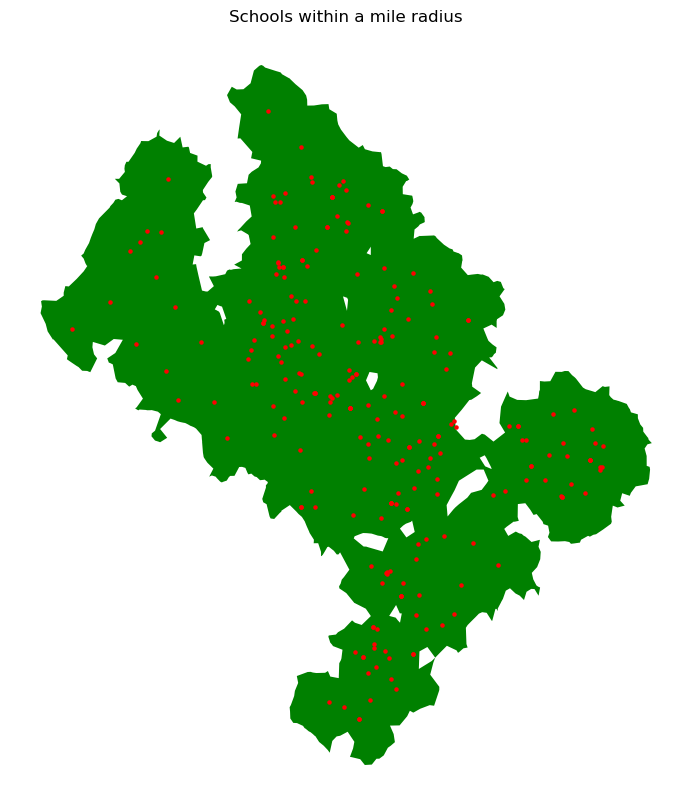

In [13]:
import matplotlib.pyplot as plt

f, ax = plt.subplots(figsize=(12, 10))

schools_iso.plot(color='green', ax=ax)

dc_schools.plot(ax=ax, color='red', markersize=5)

plt.title('Schools within a mile radius')

ax.axis('off')

plt.show()

In [14]:
# schools_iso.explore()

### DC Hospitals

In [15]:
import pandas as pd
file_path = 'data/hospitals/Hospitals.shp'

hospitals = gpd.read_file(file_path)

In [16]:
dc_hospitals = hospitals[(hospitals['STATE'] == 'DC') & (hospitals['CITY'] == 'WASHINGTON')]
#dc_hospitals

In [17]:
file_path='data/dc_healthcare/Primary_Care_Facility.shp'
healthcare=gpd.read_file(file_path)

The dataset containing information on hospitals was initially imported, and a subset was created to include only those facilities located within Washington, DC. This subset was filtered based on both the 'state' and 'city' columns to ensure that only entries for Washington, DC were retained. In addition to hospitals, the analysis also considered other types of healthcare facilities. Therefore, two distinct GeoDataFrames were created: 'dc_hospitals' for hospitals, and 'healthcare' for other healthcare facilities. The 'healthcare' GeoDataFrame encompasses a variety of non-hospital healthcare locations situated in Washington, DC

### Creating Isochrones for DC Hospitals and other Healthcare Facilities

In [18]:
iso_health = isochrones_from_gdf(healthcare, threshold=1600, network=dc_network)
iso_health

,geometry,distance
origin,,
0,"POLYGON ((-77.04919 38.92773, -77.04904 38.927...",1600
1,"POLYGON ((-77.01964 38.92378, -77.01835 38.922...",1600
2,"POLYGON ((-77.04919 38.92773, -77.04904 38.927...",1600
3,"POLYGON ((-77.00848 38.92237, -77.00848 38.921...",1600
4,"POLYGON ((-76.96136 38.91865, -76.96507 38.915...",1600
5,"POLYGON ((-76.98794 38.91473, -76.98531 38.915...",1600
6,"POLYGON ((-76.93455 38.91560, -76.93418 38.915...",1600
7,"POLYGON ((-77.02809 38.92070, -77.02758 38.920...",1600
8,"POLYGON ((-77.02587 38.92061, -77.02524 38.920...",1600


In [19]:
iso_health= iso_health.dissolve()

In [20]:
isochrones2 = isochrones_from_gdf(dc_hospitals, threshold=1600, network=dc_network)
isochrones2

,geometry,distance
origin,,
1231,"POLYGON ((-77.00973 38.93131, -77.00890 38.931...",1600
1232,"POLYGON ((-77.05648 38.89725, -77.05657 38.897...",1600
1233,"POLYGON ((-76.99571 38.93923, -76.99824 38.940...",1600
1234,"POLYGON ((-77.00848 38.92237, -77.00637 38.919...",1600
1235,"POLYGON ((-77.07518 38.90545, -77.07558 38.905...",1600
1236,"POLYGON ((-77.00973 38.93131, -77.00890 38.931...",1600
1237,"POLYGON ((-77.01225 38.93132, -77.01209 38.931...",1600
1238,"POLYGON ((-76.99912 38.94560, -76.99912 38.946...",1600
1239,"POLYGON ((-77.07719 38.93570, -77.07816 38.936...",1600


In [21]:
hospitals_iso=isochrones2.dissolve()

In [22]:
health_iso=gpd.overlay(iso_health,hospitals_iso, how='union')

In [23]:
health_iso=health_iso.dissolve()

Isochrones were generated for both the dc_hospitals and healthcare GeoDataFrames using the same dc_network and a distance threshold of 1600 meters. This threshold was chosen to represent the area accessible within approximately 15 minutes of walking or biking. Subsequently, a new GeoDataFrame named health_iso was created by performing a union of the isochrone layers from both dc_hospitals and healthcare. This combined GeoDataFrame provides a unified spatial representation of accessible healthcare services, including hospitals and other healthcare facilities, within Washington, DC.

In [24]:
health_iso['health_service']=1

Adds a new column named health_service to the health_iso GeoDataFrame and assigns a value of 1 to this column for all rows. This operation effectively marks all areas within the health_iso GeoDataFrame as having access to healthcare services, as determined by the previously defined isochrones.

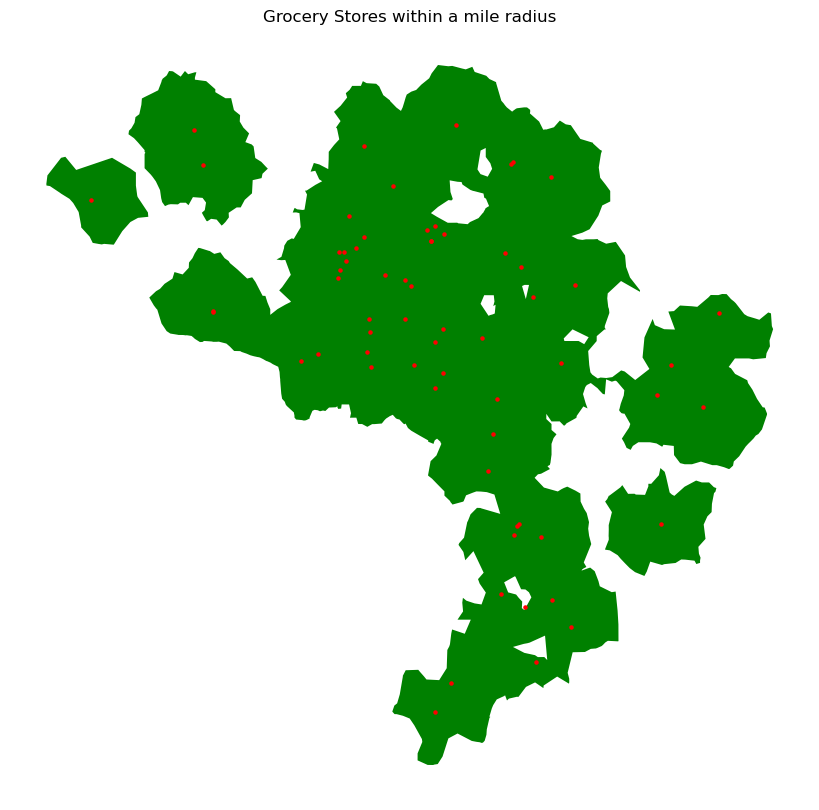

In [25]:
f, ax = plt.subplots(figsize=(12, 10))

health_iso.plot(color='green', ax=ax)

dc_hospitals.plot(ax=ax, color='red', markersize=5)

healthcare.plot(ax=ax, color='red', markersize=5)

plt.title('Healthcare Facilities within a mile radius')

ax.axis('off')

plt.show()

In [26]:
intersection_result1 = gpd.overlay(health_iso, schools_iso, how='intersection')

An intersection analysis was performed between the health_iso and schools_iso GeoDataFrames, which contain the isochrones for healthcare facilities and schools, respectively. This operation identified the geographic areas that are accessible within a 15-minute walking or biking distance to both essential services. The result, captured in the intersection_result1 GeoDataFrame, highlights the regions within Washington, DC, where residents have convenient access to both educational and healthcare facilities.

In [27]:
service_union = gpd.overlay(health_iso, schools_iso, how='union')
service_union.dissolve()

,geometry,distance_1,distance_2,health_service,distance,school_service
0,"POLYGON ((-77.01814 38.81452, -77.01814 38.816...",1600.0,1600.0,1.0,1600.0,1.0


In [28]:
dc_boundary = dc_boundary[['geometry']]
dc_boundary

,geometry
0,"POLYGON ((-77.11980 38.93435, -77.11979 38.934..."


In [29]:
service_union = gpd.overlay(service_union, dc_boundary, how='union')

In [30]:
#service_union.explore()

### DC Parks

In [31]:
file_path = 'data/dc_parks/Parks_and_Recreation_Areas.shp'
parks = gpd.read_file(file_path)

In [32]:
#parks.explore()

In [33]:
import geopandas as gpd
from shapely.geometry import Point

def sample_boundary_points(polygon, num_points=3):
    
    return [polygon.boundary.interpolate(i / num_points, normalized=True) for i in range(num_points)]

boundary_points = [pt for polygon in parks.geometry for pt in sample_boundary_points(polygon)]


boundary_gdf = gpd.GeoDataFrame(geometry=boundary_points, crs=parks.crs)

In [34]:
#boundary_gdf.explore()

'sample_boundary_points' takes a polygon and a specified number of points (num_points). It returns a list of points interpolated along the polygon's boundary. This method is particularly useful for generating points that represent possible real-world entry points into the parks, as they lie on the actual boundary rather than at the geometric center.

### Creating Isochrones for DC Parks

```isochrones3 = isochrones_from_gdf(boundary_gdf, threshold=1600, network=dc_network)```

```parks_iso = isochrones3.dissolve()```

```parks_iso.to_file("data/dc_parks_iso/parks_iso.shp")```

In [35]:
file_path="data/dc_parks_iso/parks_iso.shp"
parks_iso=gpd.read_file(file_path)

In [36]:
#parks_iso.explore()

The same threshold of 1600 meters, previously used for calculating isochrones around schools and healthcare facilities, was also applied to create isochrones for parks in Washington DC. This consistent distance metric facilitates a uniform analysis of accessibility, allowing for comparative insights into how easily different essential services—schools, healthcare facilities, and parks—are reachable within a 15-minute walk or bike ride.

In [37]:
parks_iso['park_service']=1

In [38]:
parks_iso = parks_iso.rename(columns={'distance': 'distance_parks'})

intersection_result2 = gpd.overlay(parks_iso,intersection_result1 , how='intersection')

This intersection helps to highlight regions within Washington DC where access to both parks and the previously analyzed facilities (schools and healthcare) is feasible within the same 1600 meter threshold.

In [39]:
#intersection_result2.explore()

In [40]:
service_union = gpd.overlay(service_union, parks_iso, how='union')
service_union.dissolve()

,geometry,distance_1,distance_2,health_service,distance,school_service,distance_parks,park_service
0,"POLYGON ((-77.07203 38.90107, -77.07206 38.901...",1600.0,1600.0,1.0,1600.0,1.0,1600.0,1.0


In [41]:
#service_union.explore()

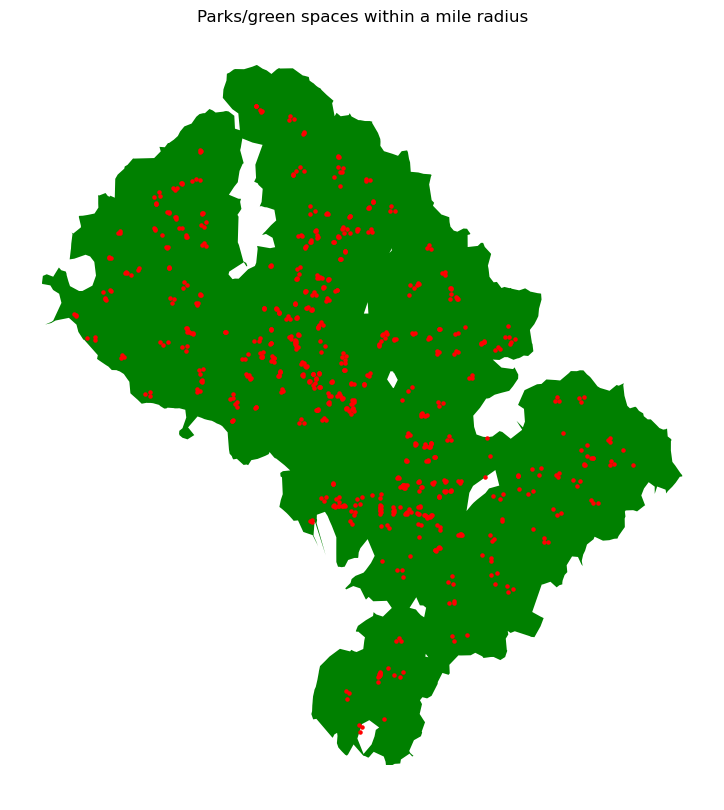

In [42]:
f, ax = plt.subplots(figsize=(12, 10))

parks_iso.plot(color='green', ax=ax)

boundary_gdf.plot(ax=ax, color='red', markersize=5)

plt.title('Parks/green spaces within a mile radius')

ax.axis('off')

plt.show()

### Transit Stops

In [43]:
file_path = 'data/dc_bus/Metro_Bus_Stops/Metro_Bus_Stops.shp'
transit = gpd.read_file(file_path)

In [44]:
#transit

##### Points were outside the DC Washington Area, had to find DC boundary and perform a spatial join.

In [45]:
file_path = 'data/dc_boundary/Washington_DC_Boundary.shp'
dc_boundary1 = gpd.read_file(file_path)

In [46]:
transit = gpd.sjoin(transit, dc_boundary1, how='inner', op='within')

In [47]:
#transit

### Creating Isochrones for Transit Stops in DC

```isochrones4 = isochrones_from_gdf(transit, threshold=1600, network=sd_network)```

```transit_iso = isochrones3.dissolve()```

```transit_iso.to_file("data/dc_transit_iso")```

In [48]:
file_path="data/dc_transit_iso/dc_transit_iso.shp"
transit_iso=gpd.read_file(file_path)

In [49]:
#transit_iso.explore()

In [50]:
transit_iso["transit_service"]=1

In [51]:
transit_iso = transit_iso.rename(columns={'distance': 'distance_transit'})

intersection_result3 = gpd.overlay(transit_iso, intersection_result2, how='intersection')

In [52]:
#intersection_result3.explore()

This intersection produces a new GeoDataFrame, intersection_result3, which contains areas where the isochrones of transit stops overlap with the combined isochrones of parks, schools, and healthcare facilities identified in intersection_result2. This final intersection highlights regions within Washington DC that are within a 1600 meter reach of all these critical urban amenities, showcasing areas with high accessibility to transit, educational, healthcare, and recreational facilities.

In [53]:
service_union = gpd.overlay(service_union, transit_iso, how='union')
service_union.dissolve()

,geometry,distance_1,distance_2,health_service,distance,school_service,distance_parks,park_service,distance_transit,transit_service
0,"MULTIPOLYGON (((-77.03902 38.79188, -77.03904 ...",1600.0,1600.0,1.0,1600.0,1.0,1600.0,1.0,1600.0,1.0


In [54]:
#service_union = gpd.overlay(service_union, dc_boundary, how='union')

In [55]:
#service_union.explore()

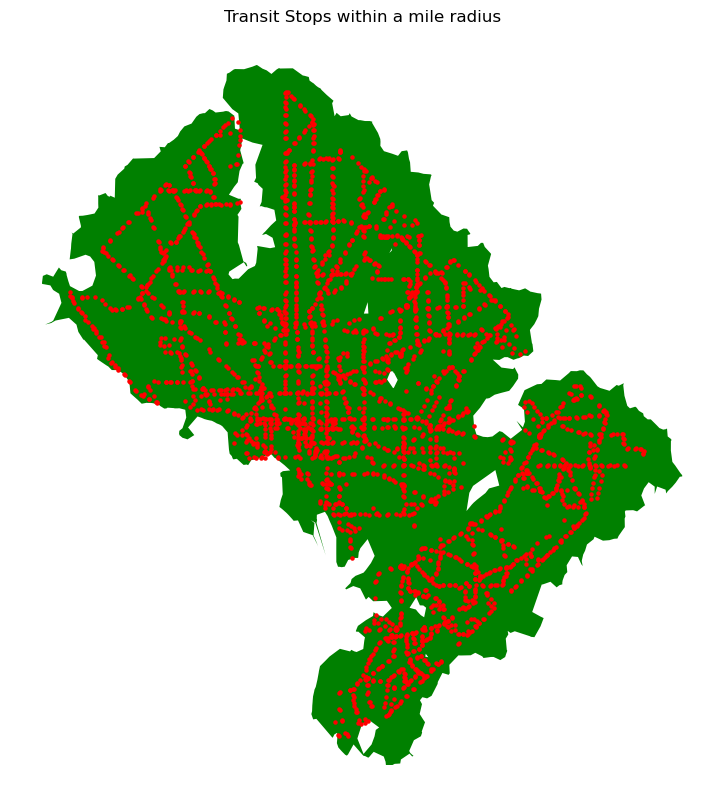

In [56]:
f, ax = plt.subplots(figsize=(12, 10))

transit_iso.plot(color='green', ax=ax)

transit.plot(ax=ax, color='red', markersize=5)

plt.title('Transit Stops within a mile radius')

ax.axis('off')

plt.show()

### Grocery Stores

In [57]:
file_path="data/dc_grocery/Grocery_Store_Locations.shp"

In [58]:
grocery = gpd.read_file(file_path)

In [59]:
#grocery.explore()

### Creating Isochrones for DC Grocery Stores

In [60]:
isochrones5 = isochrones_from_gdf(grocery, threshold=1600, network=dc_network)
isochrones5

,geometry,distance
origin,,
0,"POLYGON ((-77.03642 38.97869, -77.03686 38.979...",1600
1,"POLYGON ((-77.03642 38.97869, -77.03686 38.979...",1600
2,"POLYGON ((-77.03729 38.96875, -77.03730 38.969...",1600
3,"POLYGON ((-77.08290 38.96937, -77.08277 38.970...",1600
4,"POLYGON ((-77.08224 38.97120, -77.08152 38.971...",1600
...,...,...
79,"POLYGON ((-77.07807 38.93907, -77.07816 38.939...",1600
80,"POLYGON ((-76.96287 38.85120, -76.96349 38.850...",1600
81,"POLYGON ((-77.01212 38.83195, -77.01002 38.834...",1600


In [61]:
grocery_iso= isochrones5.dissolve()

In [62]:
grocery_iso['grocery_service']=1

In [63]:
#grocery_iso.explore()

In [64]:
grocery_iso = grocery_iso.rename(columns={'distance': 'distance_grocery'})

intersection_result4 = gpd.overlay(grocery_iso, intersection_result3, how='intersection')

In [65]:
#intersection_result4.explore()

This final intersection delineates zones within Washington DC where residents have convenient access to a full spectrum of essential services — transit, educational institutions, parks, healthcare facilities, and grocery stores — all within a 15-minute walking or biking distance.

In [66]:
service_union = gpd.overlay(service_union, grocery_iso, how='union')
service_union.dissolve()

,geometry,distance_1,distance_2,health_service,distance,school_service,distance_parks,park_service,distance_transit,transit_service,distance_grocery,grocery_service
0,"POLYGON ((-77.06713 38.89667, -77.06646 38.895...",1600.0,1600.0,1.0,1600.0,1.0,1600.0,1.0,1600.0,1.0,1600.0,1.0


In [67]:
#service_union = gpd.overlay(service_union, dc_boundary, how='union')

In [68]:
#service_union.explore()

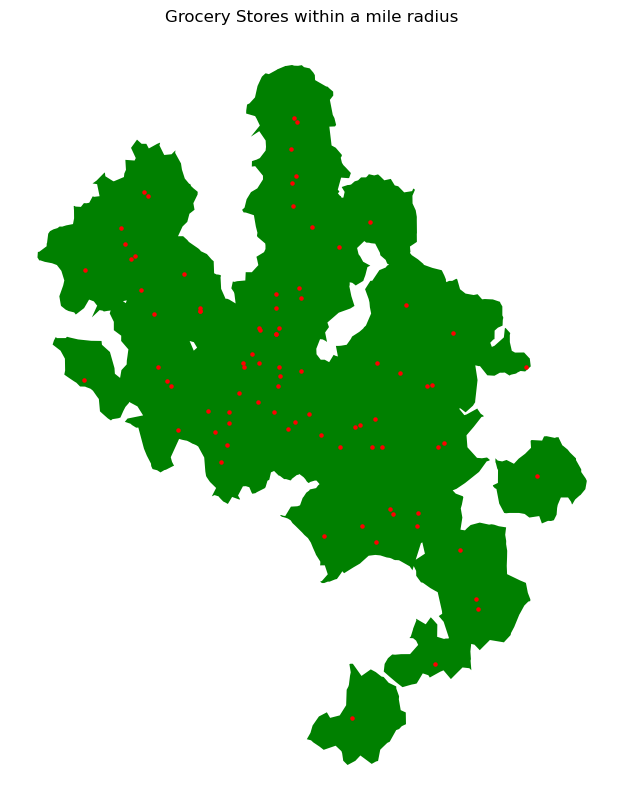

In [69]:
f, ax = plt.subplots(figsize=(12, 10))

grocery_iso.plot(color='green', ax=ax)

grocery.plot(ax=ax, color='red', markersize=5)

plt.title('Grocery Stores within a mile radius')

ax.axis('off')

plt.show()

### DC Religion

In [70]:
file_path = 'data/dc_worship/Places_of_Worship.shp'

religion = gpd.read_file(file_path)

```isochrones6 = isochrones_from_gdf(religion, threshold=1600, network=dc_network)```

```religion_iso = isochrones6.dissolve()```

```religion_iso.to_file("data/dc_religion_iso/religion_iso.shp")```

Creation of isochrones with a 15-minute (approximately 1600 meters) walking threshold around places of worship in Washington D.C. This analysis identifies the areas that can be reached within 15 minutes on foot from these religious sites.

In [71]:
file_path = 'data/dc_religion_iso/religion_iso.shp'
religion_iso = gpd.read_file(file_path)

In [72]:
religion_iso["religion_service"]=1

In [73]:
religion_iso = religion_iso.rename(columns={'distance': 'distance_religion'})

intersection_result5 = gpd.overlay(religion_iso, intersection_result4, how='intersection')

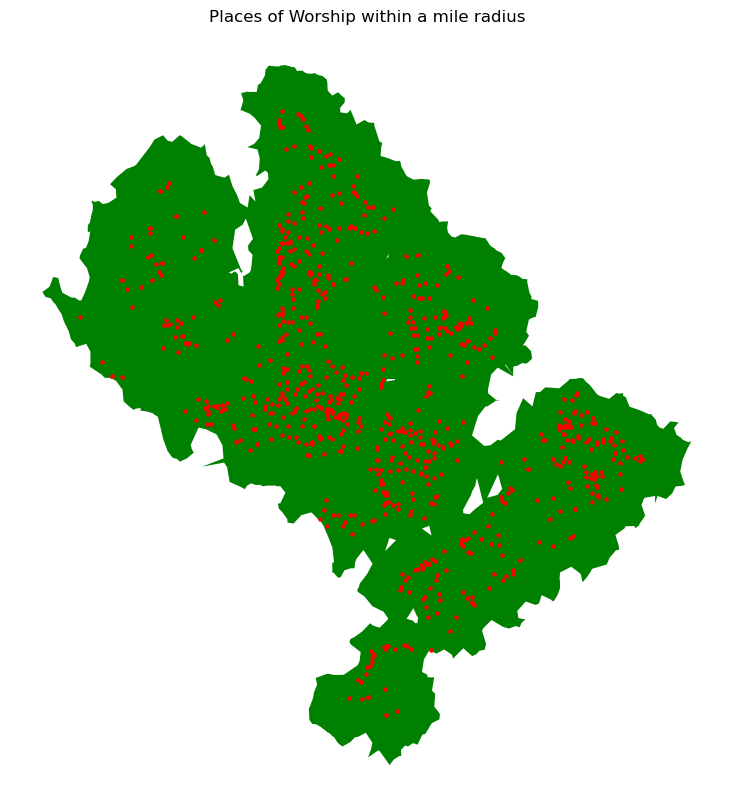

In [74]:
f, ax = plt.subplots(figsize=(12, 10))

religion_iso.plot(color='green', ax=ax)

religion.plot(ax=ax, color='red', markersize=5)

plt.title('Places of Worship within a mile radius')

ax.axis('off')

plt.show()

Renamed the 'distance' column in the religion isochrones layer to 'distance_religion' for clarity. Then, performed an intersection of this modified layer with a previous result that includes isochrones for schools, healthcare facilities, grocery stores, transit stops, and parks in Washington D.C. This intersection analysis helps understand the overlap of areas accessible within a 15-minute walk from both religious sites and these essential services.

## Spatial Analysis
---

In [75]:
service_union = gpd.overlay(service_union, religion_iso, how='union')
service_union.dissolve()

,geometry,distance_1,distance_2,health_service,distance,school_service,distance_parks,park_service,distance_transit,transit_service,distance_grocery,grocery_service,distance_religion,religion_service
0,"POLYGON ((-77.06713 38.89667, -77.06646 38.895...",1600.0,1600.0,1.0,1600.0,1.0,1600.0,1.0,1600.0,1.0,1600.0,1.0,1600.0,1.0


In [76]:
#service_union = gpd.overlay(service_union, dc_boundary, how='union')

In [77]:
#service_union.explore()

In [78]:
service_union = gpd.overlay(service_union, dc_boundary, how='intersection')

In [79]:
#service_union.explore()

### Created a GeoDataFrame 'within_boundary'

In [80]:
within_boundary = gpd.overlay(intersection_result5, dc_boundary, how='intersection')


In [81]:
#within_boundary.explore()

Some of the generated isochrones extended beyond the Washington DC boundary. To address this, an intersection operation was performed between the DC boundary and the isochrones. This step effectively trimmed the isochrones, ensuring they only encompass areas within the official city limits, thereby maintaining the geographic accuracy of the analysis.

In [82]:
within_boundary['access']='access'

A new column named "access" was added to the isochrones GeoDataFrame to denote the areas that provide access to all essential services outlined previously, including transit stops, schools, parks, hospitals, and grocery stores.

### Import of American Community Survey Data using GeoSnap

In [83]:
acs21 = datasets.acs('2021')

<Axes: >

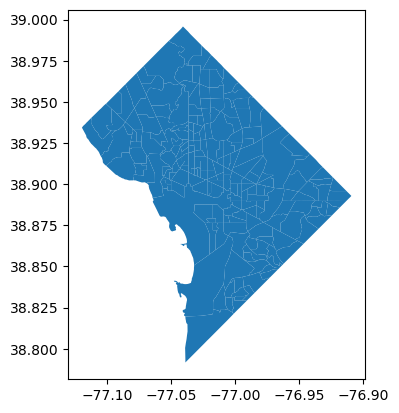

In [84]:
dc_tracts = acs21[acs21['geoid'].str.startswith('11')]
dc_tracts.plot()

In [85]:
dc_tracts.crs

<Geographic 2D CRS: EPSG:4269>
Name: NAD83
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: North America - onshore and offshore: Canada - Alberta; British Columbia; Manitoba; New Brunswick; Newfoundland and Labrador; Northwest Territories; Nova Scotia; Nunavut; Ontario; Prince Edward Island; Quebec; Saskatchewan; Yukon. Puerto Rico. United States (USA) - Alabama; Alaska; Arizona; Arkansas; California; Colorado; Connecticut; Delaware; Florida; Georgia; Hawaii; Idaho; Illinois; Indiana; Iowa; Kansas; Kentucky; Louisiana; Maine; Maryland; Massachusetts; Michigan; Minnesota; Mississippi; Missouri; Montana; Nebraska; Nevada; New Hampshire; New Jersey; New Mexico; New York; North Carolina; North Dakota; Ohio; Oklahoma; Oregon; Pennsylvania; Rhode Island; South Carolina; South Dakota; Tennessee; Texas; Utah; Vermont; Virginia; Washington; West Virginia; Wisconsin; Wyoming. US Virgin Islands. British Virgin Islands

In [86]:
dc_tracts = dc_tracts.to_crs(epsg=4326)


In [87]:
union = gpd.overlay(dc_tracts,within_boundary, how='union')

In [88]:
union.columns

Index(['geoid', 'n_mexican_pop', 'n_cuban_pop', 'n_puerto_rican_pop',
       'n_russian_pop', 'n_italian_pop', 'n_german_pop', 'n_irish_pop',
       'n_scandaniavian_pop', 'n_foreign_born_pop',
       ...
       'transit_service', 'distance_parks', 'park_service', 'distance_1',
       'distance_2', 'health_service', 'distance', 'school_service', 'access',
       'geometry'],
      dtype='object', length=172)

A union operation was executed between the dc_tracts GeoDataFrame and the within_boundary GeoDataFrame to merge areas both inside and outside the isochrones. This process resulted in a modified geometry for the tracts in Washington DC, effectively differentiating between tracts covered by the isochrones and those that are not, thereby providing a comprehensive spatial representation of service accessibility across the city.

In [89]:
union.fillna('no_access', inplace=True)

In [90]:
import tobler

In [91]:
interpolated_data = tobler.area_weighted.area_interpolate(
    dc_tracts,
     union,
    extensive_variables=['n_total_pop'],
   intensive_variables=['per_capita_income','p_nonhisp_black_persons', 'p_hispanic_persons', 
                        'p_nonhisp_white_persons','p_asian_persons']
)

In [92]:
interpolated_data['access'] = union.access

In [93]:
# interpolated_data.explore(column='access', cmap='coolwarm', legend=True)

```interpolated_data.to_file('data/dc_interpolation')```

In [94]:
import pandas as pd
pd.options.display.float_format='{:.0f}'.format

In [95]:
interpolated_data[['n_total_pop', 'access']].groupby(by='access').sum()


,n_total_pop
access,
access,471920
no_access,211234


### Number of Services

In [96]:
service_union.fillna(0, inplace=True)

In [97]:
#service_union

In [98]:
service_union['combined_services']=service_union['transit_service'] + service_union['park_service']+service_union['health_service']+service_union['school_service']+service_union['grocery_service']+service_union['religion_service']

In [99]:
# service_union.explore(column='combined_services', legend=True)

In [100]:
service_union.to_file('./data/services/service_union')

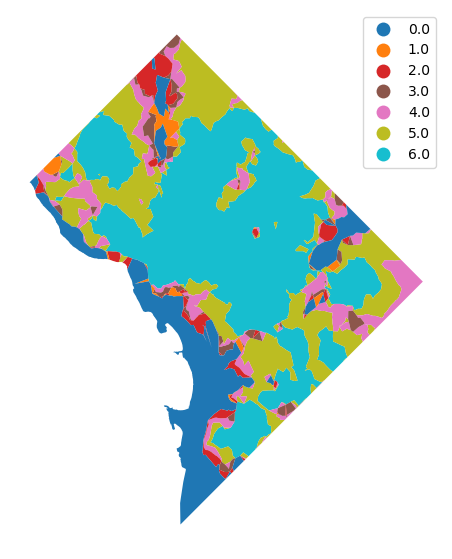

In [101]:
import matplotlib.pyplot as plt
f, ax = plt.subplots(1, figsize=(7, 7))
service_union.plot(
    column="combined_services", categorical=True, legend=True, linewidth=0, ax=ax
)

plt.title('The distribution of total services within Washington DC')
ax.set_axis_off()
plt.show()